In [1]:
%run Data_Import_Cleaning.ipynb
tech_data = get_tech_data()

## Tech Exploratory Data Analysis

In the EDA I want to look at different things related to the technician information. Things such as:
1. Currently employed vs former technicians
2. Number of techs over time
3. Technician tenure
4. others as thought of

In [2]:
tech_data.head()

,Enterprise,Contract_Type,State,AR#,Dealer,Emp_SN,Employees,Start_dt,Term_dt,Account_Control,YOE
0,Liftow Limited,Full-Line,NS,05520,"Bobcat Atlantic, Dartmouth, NS",00000093,1,2004-10-16,2017-03-03,DEACTIVATED,12.38
1,"Best Line Leasing, Inc.",Full-Line,PA,01436,"Best Line Leasing, Inc, Pennsdale, PA",00000107,1,2004-10-16,2020-01-07,DEACTIVATED,15.23
2,"Streacker Tractor Sales, Inc.",Construction,OH,08788,"Streacker Tractor Sales, Inc, Findlay, OH",00000153,1,2004-10-16,NaT,ACTIVATED,19.65
3,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",00000204,1,2004-10-16,2014-05-14,DEACTIVATED,9.57
4,"Smith Bros. Contracting Equipment, Inc.",Full-Line,FL,05469,"Bobcat of Palm Beach, West Palm Beach, FL",00000231,1,2004-10-16,2008-02-15,DEACTIVATED,3.33


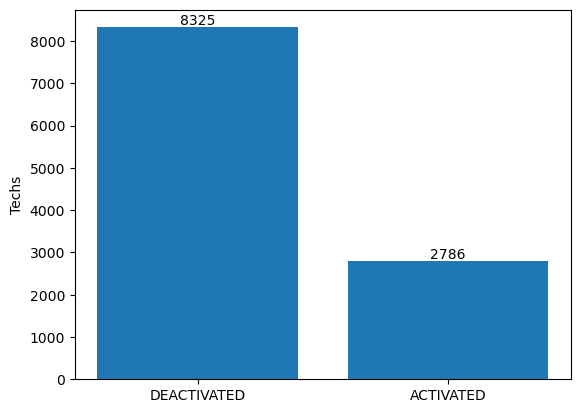

In [3]:
# active vs non-active techs
fig, ax = plt.subplots()
counts = tech_data['Account_Control'].value_counts().values
labs = tech_data['Account_Control'].value_counts().index
rects = ax.bar(labs, counts)
ax.bar_label(rects, counts)
ax.set_ylabel("Techs")

plt.show()

In [4]:
# Getting a single DF that counts terminated and starting by date
techs_start_date = tech_data.groupby('Start_dt').agg({'Employees': ['count']})
techs_term_date = tech_data.groupby('Term_dt').agg({'Employees': ['count']})
techs_date = techs_start_date.merge(techs_term_date, how='outer', left_index=True, right_index=True)

# Want date to be column not index for graphing purposes
techs_date.reset_index(inplace=True)
techs_date.columns = ['Date', 'Starting', 'Terminated']

#Will be grouping by month, so creating month column
techs_date['Month'] = (
    pd.to_datetime(
        dict(
            year=techs_date['Date'].dt.year, 
            month=techs_date['Date'].dt.month, 
            day=1
        )
))

In [5]:
# Summarize by month
techs_date_month = techs_date.groupby('Month').agg({'Starting': 'sum', 'Terminated': 'sum'})
techs_date_month['Growth'] = (techs_date_month['Starting'] - techs_date_month['Terminated']).astype(int)
techs_date_month['Employees'] = techs_date_month['Growth'].cumsum()
techs_date_month.reset_index(inplace=True)
techs_date_month

,Month,Starting,Terminated,Growth,Employees
0,2004-10-01,76.0,0.0,76,76
1,2004-11-01,17.0,0.0,17,93
2,2004-12-01,9.0,0.0,9,102
3,2005-01-01,6.0,0.0,6,108
4,2005-02-01,8.0,0.0,8,116
...,...,...,...,...,...
229,2023-12-01,86.0,56.0,30,2858
230,2024-01-01,136.0,117.0,19,2877
231,2024-02-01,107.0,114.0,-7,2870
232,2024-03-01,110.0,268.0,-158,2712


## Number of Employees Trending

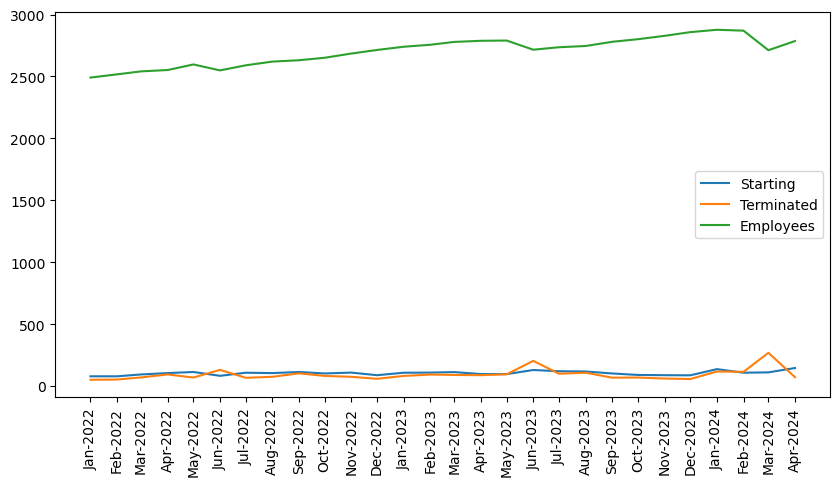

In [6]:
# Plot starting and ending counts
data = techs_date_month[techs_date_month['Month'] >= pd.to_datetime(date(2022, 1, 1))]
fig, ax1 = plt.subplots(figsize=(10,5))
x=data['Month']
cols = ['Starting', 'Terminated', 'Employees']
h=data[cols]
ax1.plot(x, h, label=cols)
ax1.legend()


plt.xticks(x, rotation=90)
ax1.xaxis.set_major_formatter(dates.DateFormatter('%b-%Y'))
plt.show()

The same graph would look better if the y-axis is split

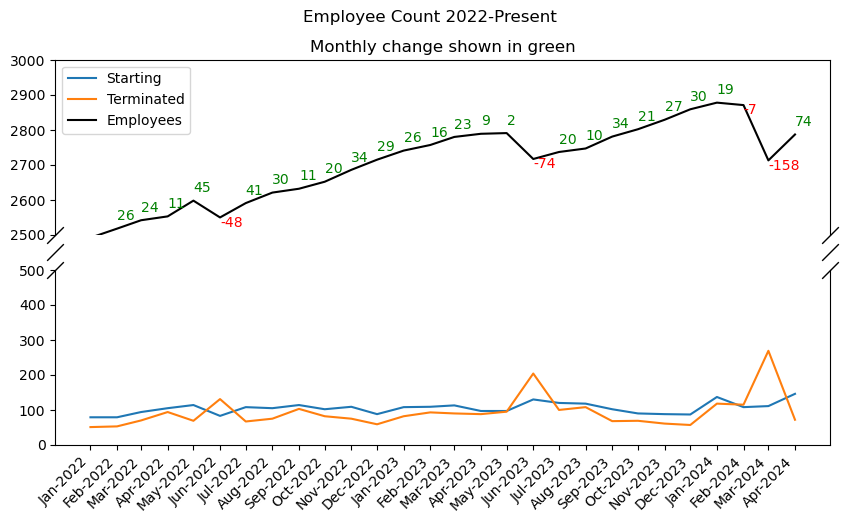

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
x=data['Month']
cols = ['Starting', 'Terminated']
h=data[cols]

fig.suptitle('Employee Count 2022-Present')
ax1.set_title('Monthly change shown in green')

ax1.plot(x, h, label=cols)
ax1.plot(x, data['Employees'], color='k', label='Employees')

ax2.plot(x, h, label=cols)
ax2.plot(x, data['Employees'], color='k')

ax1.set_ylim(2500, 3000) #highdata
ax2.set_ylim(0, 500) # Starting/Terminated data
ax1.legend()

# Adding the monthly growth for data labels
for x1, y1, lab in zip(data['Month'], data['Employees'], data['Growth']):
    if lab>=0:
        ax1.annotate(lab, xy=(x1,y1), xytext=(x1, y1+25), color='g')
    else:
        ax1.annotate(lab, xy=(x1,y1), xytext=(x1, y1-25), color='r')

# 'merging' the axis
ax1.spines.bottom.set_visible(False) #removes bottom line from topgraph
ax2.spines.top.set_visible(False) #removes top line from topgraph
ax1.xaxis.tick_top() #removes month labels for top graph
ax1.tick_params(top=False, labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

#creating the hash marks were the axis breaks
# (0,0), (0,1),(1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.
d = 1  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", # slashes won't be connected
              color='k', 
              mec='k', #marker edge color = black
              mew=1, #marker edge width
              clip_on=False #allows the slashes to appear outside of the figures
             )
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([0, 1], [1.1, 1.1], transform=ax2.transAxes, **kwargs)

plt.xticks(x, rotation=45, ha='right')
ax2.xaxis.set_major_formatter(dates.DateFormatter('%b-%Y'))
plt.show()

In [8]:
del data

## Technician Tenure

In [9]:
tech_data.head()

,Enterprise,Contract_Type,State,AR#,Dealer,Emp_SN,Employees,Start_dt,Term_dt,Account_Control,YOE
0,Liftow Limited,Full-Line,NS,05520,"Bobcat Atlantic, Dartmouth, NS",00000093,1,2004-10-16,2017-03-03,DEACTIVATED,12.38
1,"Best Line Leasing, Inc.",Full-Line,PA,01436,"Best Line Leasing, Inc, Pennsdale, PA",00000107,1,2004-10-16,2020-01-07,DEACTIVATED,15.23
2,"Streacker Tractor Sales, Inc.",Construction,OH,08788,"Streacker Tractor Sales, Inc, Findlay, OH",00000153,1,2004-10-16,NaT,ACTIVATED,19.65
3,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",00000204,1,2004-10-16,2014-05-14,DEACTIVATED,9.57
4,"Smith Bros. Contracting Equipment, Inc.",Full-Line,FL,05469,"Bobcat of Palm Beach, West Palm Beach, FL",00000231,1,2004-10-16,2008-02-15,DEACTIVATED,3.33


In [10]:
data = tech_data
summary_stats = data['YOE'].describe()
summary_stats

count    11111.000000
mean         2.499537
std          3.375410
min          0.000000
25%          0.480000
50%          1.260000
75%          2.930000
max         19.650000
Name: YOE, dtype: float64

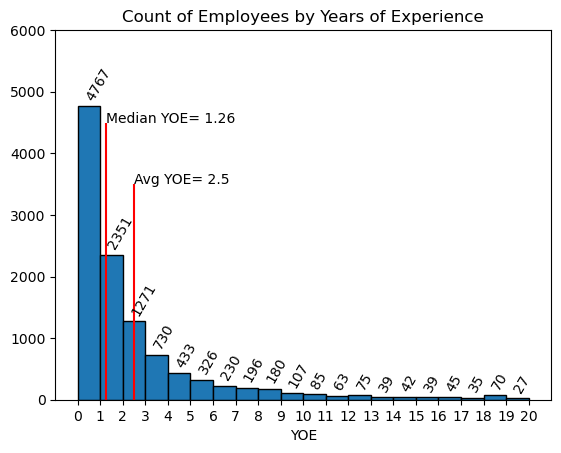

In [11]:
fig, ax = plt.subplots()
x=data['YOE']


hist, bin_edges = np.histogram(data['YOE'], range=(0,np.ceil(summary_stats['max'])), bins=20)
ax.hist(x, bin_edges, edgecolor='k')

#Adding mean and median lines
x_mean = x.mean().round(2)
ax.vlines(x_mean, ymin=0, ymax=3500, colors='r')
ax.annotate(f'Avg YOE= {x_mean}', xy=(x_mean, 3500), )

x_median = x.median()
ax.vlines(x_median, ymin=0, ymax=4500, colors='r')
ax.annotate(f'Median YOE= {x_median}', xy=(x_median, 4500), )



ax.set_title('Count of Employees by Years of Experience')
ax.set_xlabel('YOE')


for i,j in zip(hist, bin_edges):
    ax.annotate(i, xy=(j,i), rotation=60, xytext=(j+.25, i+100))
    
plt.ylim(top=6000)
plt.xticks(bin_edges)
plt.show()


In [12]:
keep_cols=['YOE', 'Account_Control']
tech_data[keep_cols].groupby('Account_Control').describe()

YOE                                                   
                  count      mean       std   min   25%   50%   75%    max
Account_Control                                                           
ACTIVATED        2786.0  3.833367  4.602901  0.14  0.76  1.94  4.92  19.65
DEACTIVATED      8325.0  2.053165  2.706185  0.00  0.42  1.11  2.50  19.36

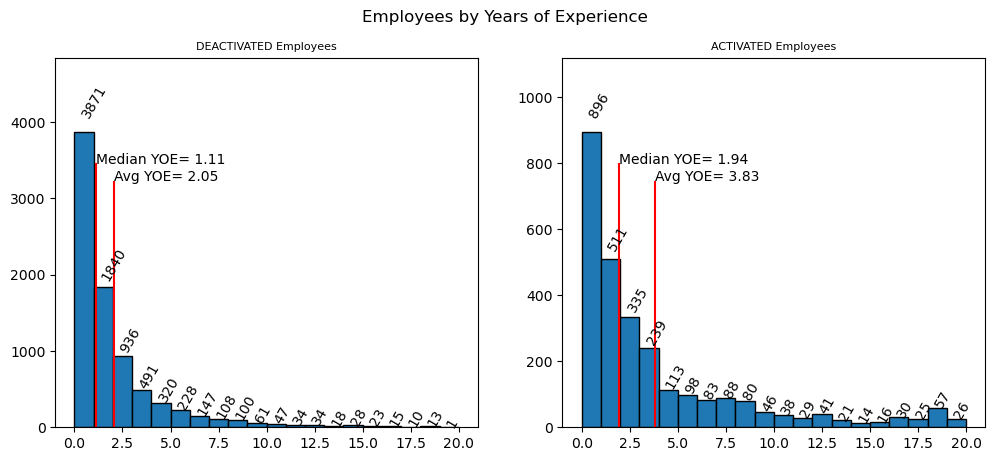

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(12)
status = ['DEACTIVATED', 'ACTIVATED']
axes = [ax1, ax2]

for ind in [0,1]:
    x = tech_data[tech_data['Account_Control']==status[ind]]['YOE']
    hist, bin_edges = np.histogram(x, range=(0,np.ceil(summary_stats['max'])), bins=20)
    y_limit=hist.max()*1.25
    axes[ind].hist(x, bin_edges, edgecolor='k')

    #Adding mean and median lines
    x_mean = x.mean().round(2)
    axes[ind].vlines(x_mean, ymin=0, ymax=y_limit/1.5, colors='r')
    axes[ind].annotate(f'Avg YOE= {x_mean}', xy=(x_mean, y_limit/1.5), )

    x_median = x.median()
    axes[ind].vlines(x_median, ymin=0, ymax=y_limit/1.4, colors='r')
    axes[ind].annotate(f'Median YOE= {x_median}', xy=(x_median, y_limit/1.4), )

    for i,j in zip(hist, bin_edges):
        axes[ind].annotate(i, xy=(j,i), rotation=60, xytext=(j+.25, i*1.05))
        
    axes[ind].set_title(f'{status[ind]} Employees', fontsize=8)
    #axes[ind].set_xticks(bin_edges)
    axes[ind].set_ylim(0, y_limit)

plt.suptitle('Employees by Years of Experience')       
plt.show()

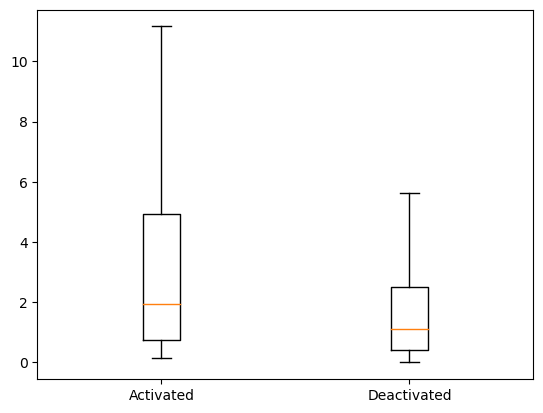

In [14]:
fig, ax = plt.subplots()
x_active= tech_data['YOE'][tech_data['Account_Control']=="ACTIVATED"]
x_deactive = tech_data['YOE'][tech_data['Account_Control']=="DEACTIVATED"]

ax.boxplot([x_active, x_deactive], labels=['Activated', 'Deactivated'], sym='')
plt.show()

In [15]:
data

,Enterprise,Contract_Type,State,AR#,Dealer,Emp_SN,Employees,Start_dt,Term_dt,Account_Control,YOE
0,Liftow Limited,Full-Line,NS,05520,"Bobcat Atlantic, Dartmouth, NS",00000093,1,2004-10-16,2017-03-03,DEACTIVATED,12.38
1,"Best Line Leasing, Inc.",Full-Line,PA,01436,"Best Line Leasing, Inc, Pennsdale, PA",00000107,1,2004-10-16,2020-01-07,DEACTIVATED,15.23
2,"Streacker Tractor Sales, Inc.",Construction,OH,08788,"Streacker Tractor Sales, Inc, Findlay, OH",00000153,1,2004-10-16,NaT,ACTIVATED,19.65
3,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",00000204,1,2004-10-16,2014-05-14,DEACTIVATED,9.57
4,"Smith Bros. Contracting Equipment, Inc.",Full-Line,FL,05469,"Bobcat of Palm Beach, West Palm Beach, FL",00000231,1,2004-10-16,2008-02-15,DEACTIVATED,3.33
...,...,...,...,...,...,...,...,...,...,...,...
11106,Wood's Machinery,Full-Line,NJ,09497,"Bobcat of Hainesport, Hainesport, NJ",50014864,1,2024-04-17,NaT,ACTIVATED,0.15
11107,Bobcat of Fort Wayne,Full-Line,IN,00081,"Bobcat of Fort Wayne, Fort Wayne, IN",50014884,1,2024-04-17,NaT,ACTIVATED,0.15
11108,"RECO Equipment, Inc.",Full-Line,OH,02779,"Bobcat of Toledo, Walbridge, OH",50015115,1,2024-04-19,NaT,ACTIVATED,0.14
11109,Leppo Inc - OH,Full-Line,OH,05468,"Bobcat of Akron, Tallmadge, OH",50015118,1,2024-04-19,NaT,ACTIVATED,0.14


## Censored Data Custom Graph

In [16]:
#01034
samp = tech_data[tech_data['AR#']=='01034'].sort_values(by=['Start_dt', 'Term_dt']).reset_index()

#
max_date=date.today()
samp

,index,Enterprise,Contract_Type,State,AR#,Dealer,Emp_SN,Employees,Start_dt,Term_dt,Account_Control,YOE
0,3,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",00000204,1,2004-10-16,2014-05-14,DEACTIVATED,9.57
1,289,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",00012204,1,2006-01-11,2024-03-29,DEACTIVATED,18.21
2,291,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",00012212,1,2006-01-12,2019-09-03,DEACTIVATED,13.64
3,343,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",00012435,1,2006-01-30,2010-12-16,DEACTIVATED,4.88
4,928,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",01008850,1,2007-10-02,2011-12-20,DEACTIVATED,4.22
5,1139,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",01012058,1,2008-06-19,2014-04-28,DEACTIVATED,5.86
6,1223,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",01013271,1,2008-10-27,2011-12-20,DEACTIVATED,3.15
7,1926,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",01033631,1,2012-05-09,NaT,ACTIVATED,12.08
8,1927,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",01033641,1,2012-05-10,2013-01-21,DEACTIVATED,0.70
9,2026,"Bobcat Plus, Inc.",Full-Line,WI,01034,"Bobcat Plus, Inc, Butler, WI",01035596,1,2012-08-16,2014-09-04,DEACTIVATED,2.05


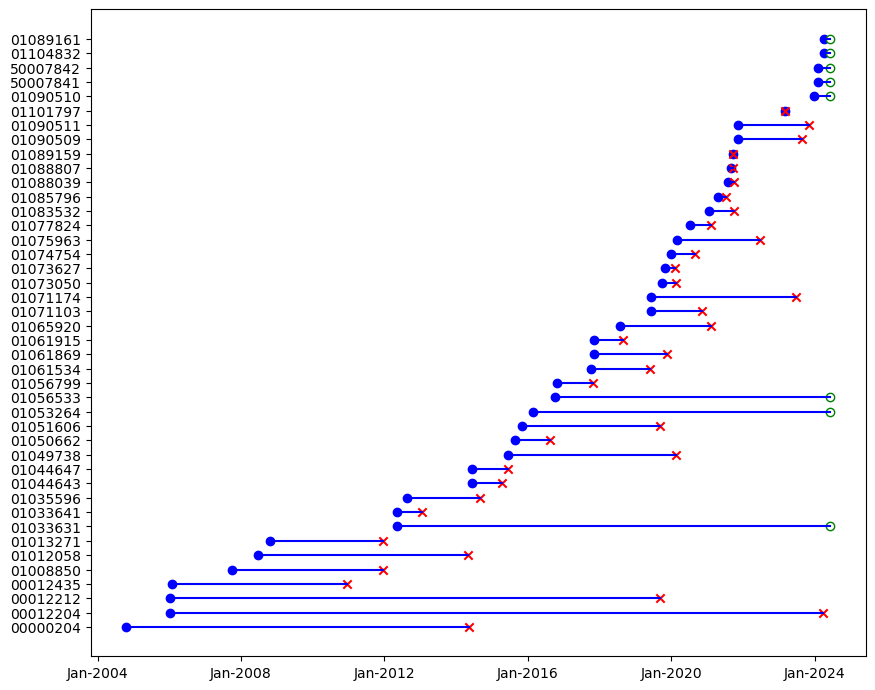

In [17]:
height = samp.shape[0]/5
fig, ax = plt.subplots(figsize=(10, height))

#plotting terminated date icon
for start, end, SN, status in zip(samp['Start_dt'], samp['Term_dt'], samp['Emp_SN'], samp['Account_Control']):
    
    #plotting start date icon
    ax.scatter(start, SN, c='b')
   
    #plotting end point icon and connector line
    if status=='DEACTIVATED':
        x_pts = [start, end]
        y_pts = [SN, SN]
        ax.plot(x_pts, y_pts, color='b')
        ax.scatter(end, SN, marker='x', c='r')
    
    else:
        ax.scatter(date.today(), SN, marker='o', color='w', edgecolor='green')
        x_pts = [start, max_date]
        y_pts = [SN, SN]
        ax.plot(x_pts, y_pts, color='b')

ax.xaxis.set_major_formatter(dates.DateFormatter('%b-%Y'))

plt.show()

In [86]:
def plot_tenure_graph(AR):
    
    #subsetting data and calculating summary statistics
    samp = tech_data[tech_data['AR#']==AR].sort_values(by=['Start_dt', 'Term_dt']).reset_index()
    height = samp.shape[0]/5
    dealer_name = samp['Dealer'][0]
    avg_tenure = samp['YOE'].mean().round(2)
    active_techs = samp['Account_Control'][samp['Account_Control'] == 'ACTIVATED'].shape[0]
    inactive_techs = samp['Account_Control'][samp['Account_Control'] == 'DEACTIVATED'].shape[0]
    
    
    # creating graph
    fig, ax = plt.subplots(figsize=(10, height))
    plt.title(dealer_name)

    

    #plotting terminated date icon
    for start, end, SN, status, YOE in zip(samp['Start_dt'], samp['Term_dt'], samp['Emp_SN'], samp['Account_Control'], samp['YOE']):

        #plotting start date icon
        ax.scatter(start, SN, c='b')
        ax.annotate(YOE, xy=(start, SN), xytext=(-40, -5), textcoords = 'offset pixels')
        
        #plotting end point icon and connector line
        if status=='DEACTIVATED':
            x_pts = [start, end]
            y_pts = [SN, SN]
            ax.plot(x_pts, y_pts, color='b')
            ax.scatter(end, SN, marker='x', c='r')

        else:
            ax.scatter(date.today(), SN, marker='o', color='w', edgecolor='green')
            x_pts = [start, max_date]
            y_pts = [SN, SN]
            ax.plot(x_pts, y_pts, color='b')

    ax.xaxis.set_major_formatter(dates.DateFormatter('%b-%Y'))
    
    plt.show()
    print(
        (f'Dealer Technician Summary Statistics:\n'
        f'Total Technicians: {active_techs+inactive_techs}\n'
        f'Active Technicians: {active_techs}\n'
        f'Average Employment: {avg_tenure}'
        )
    )


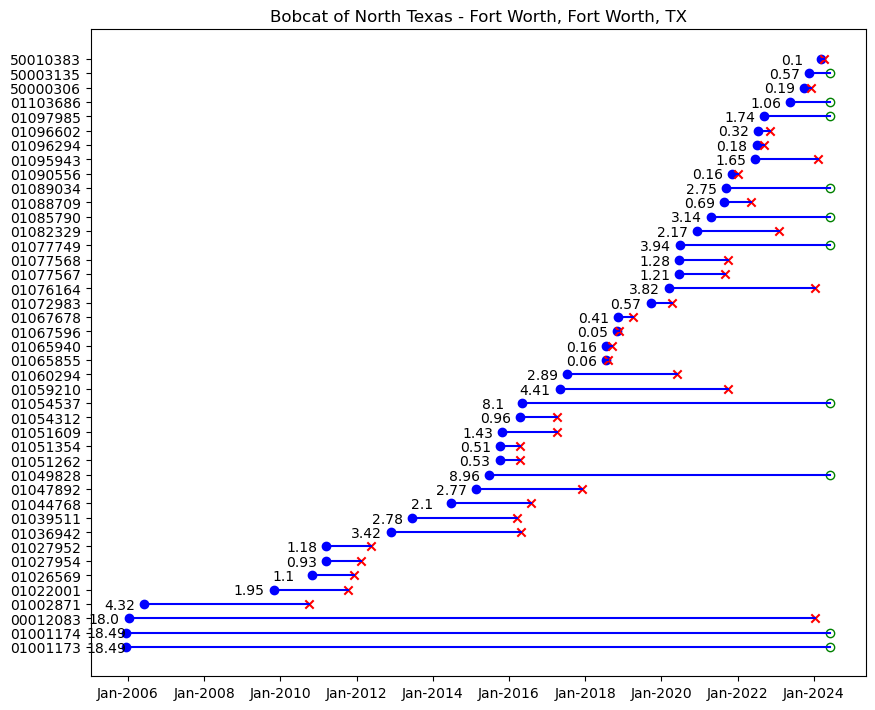

Dealer Technician Summary Statistics:
Total Technicians: 42
Active Technicians: 10
Average Employment: 3.08


In [88]:
plot_tenure_graph('00657')

In [90]:
tech_data[tech_data['Emp_SN'] == '01001174']

,Enterprise,Contract_Type,State,AR#,Dealer,Emp_SN,Employees,Start_dt,Term_dt,Account_Control,YOE
436,Bobcat of Dallas,Full-Line,TX,00657,"Bobcat of North Texas - Fort Worth, Fort Worth...",01001174,1,2005-12-12,NaT,ACTIVATED,18.49
